In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
path = 'data/FFR_pre_2008.csv'
df_pre_2008 = pd.read_csv(path, low_memory=False)

path = 'data/FFR_post_2008.csv'
df_post_2008 = pd.read_csv(path, low_memory=False)


In [26]:
df_pre_2008.columns = ['date', 'ffr']
df_post_2008.columns = ['date', 'ffr']

df = pd.concat([df_pre_2008, df_post_2008], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df.isna().sum()

date    0
ffr     0
dtype: int64

In [28]:
df.describe()

,date,ffr
count,369,369.000000
mean,2009-05-17 08:07:48.292683008,2.618385
min,1994-01-01 00:00:00,0.250000
25%,2001-09-01 00:00:00,0.250000
50%,2009-06-01 00:00:00,1.925000
75%,2017-02-01 00:00:00,5.250000
max,2024-10-01 00:00:00,6.500000
std,NaN,2.204462


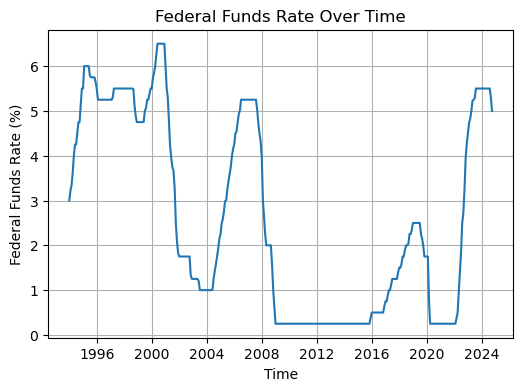

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(df.date, df.ffr)
plt.title('Federal Funds Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Federal Funds Rate (%)')
plt.grid()
plt.show()

In [42]:
date = pd.to_datetime('1994-01-01')
month = pd.DateOffset(months=1)
while date < pd.to_datetime('2024-12-01'):
    if date not in df['date'].values:
        print('missing: '+str(date))
    date += month

df.date

missing: 2008-12-01 00:00:00
missing: 2024-11-01 00:00:00


0     1994-01-01
1     1994-02-01
2     1994-03-01
3     1994-04-01
4     1994-05-01
         ...    
364   2024-06-01
365   2024-07-01
366   2024-08-01
367   2024-09-01
368   2024-10-01
Name: date, Length: 369, dtype: datetime64[ns]